In [210]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools.assignment6 as im
import imagetools as im0
%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Spectral Deconvolution

In [211]:
def plot_transform_im(x):
    fig, axes = plt.subplots(ncols=2, figsize=(7,3))
    im0.show(x, ax=axes[0])
    im0.showfft(x, ax=axes[1], apply_fft=True, apply_log=True)
    fig.show()


In [212]:
x1 = plt.imread('assets/sheeps.png')
x2 = plt.imread('assets/plane.png')
x3 = plt.imread('assets/eagle.png')

x = (x1,x2,x3)

x_hat = np.fft.fft2(x[:][1])
print(np.abs(x_hat).shape)

(321, 481, 3)


## Question 1

In [213]:
def average_power_spectral_density(x):
    #extract individual imagses from list
    k = len(x)
    S_avg = np.zeros_like(x[:][0])
    ax = range(np.ndim(x[:][0]))
    for i in range(k):
        #get the fourier transform of the images 
        x_hat = np.fft.fft2(x[:][i], axes=ax)
        #get the absolute value squared
        x_hat_2 = np.square(np.absolute(x_hat))
        #do a running sum
        S_avg+= x_hat_2
    return np.mean(S_avg/k, axis=-1)

## Question 2

<IPython.core.display.Javascript object>


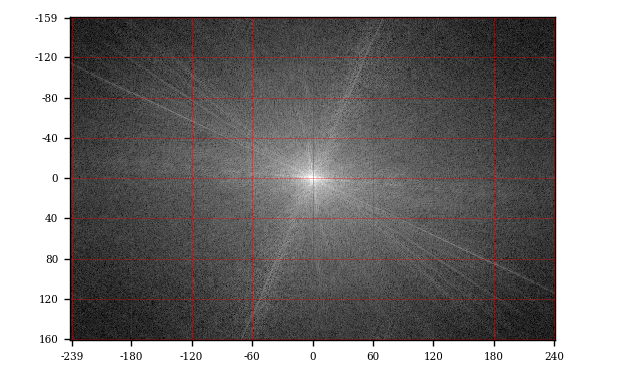

(321, 481)

In [227]:
apsd = average_power_spectral_density(x)
im0.showfft(apsd, apply_log=True, vmin=-10, vmax=5)
apsd.shape

## Question 3 and 4

$\frac{\partial S_{u,v}}{\partial \alpha} = \alpha\Sigma t_{u,v}^2 + \beta \Sigma t_{u,v} - \Sigma s_{u,v}^{(avg)}t_{u,v} $

and

$\frac{\partial S_{u,v}}{\partial \beta} = \alpha\Sigma t_{u,v} + \beta \Sigma 1 - \Sigma s_{u,v}^{(avg)}$

Solving for $\alpha, \beta$

$$
\begin{pmatrix} 
\alpha \newline
\beta
\end{pmatrix}

\begin{pmatrix} 
\Sigma t_{u,v}^2 & \Sigma t_{u,v}\newline
\beta
\end{pmatrix}

$$

## Question 5

In [235]:
def mean_power_spectrum_density(apsd):
    n1, n2 = apsd.shape

    W_uv = np.zeros_like(apsd)
    mpsd = np.zeros_like(apsd)
    u,v = im0.fftgrid(n1, n2)
    W_uv = ((u/n1)**2 + (v/n2)**2)**0.5
    W_uv[0,0] =0.00001
    T_uv = np.log(W_uv)
    T_uv_2 = np.square(T_uv)
    s_uv = np.log(apsd)-np.log(n1)-np.log(n2)
    st_uv = s_uv*T_uv
    
    #finally
    Q = np.zeros((2,2))
    Q[0,0] = np.sum(T_uv_2)
    Q[0,1] = np.sum(T_uv)
    Q[1,0] = np.sum(T_uv)
    Q[1,1] = n1*n2
    
    
    s = np.zeros((2,1))
    
    s[0,:] = np.sum(st_uv)
    s[1,:] = np.sum(s_uv)
    alph_bet = np.zeros_like(s)
    
    alph_bet = np.matmul(np.linalg.inv(Q),s) 

    
    alpha = alph_bet[0,:]
    beta = alph_bet[1,:]
    
    W_uv_a = W_uv**alpha
    
    mpsd = n1*n2*(np.exp(beta))*W_uv_a
    
    mpsd[0, 0] = np.inf
    return mpsd, alpha, beta

## Question 6

In [467]:
mpsd, alpha, beta = mean_power_spectrum_density(apsd)

In [497]:
print(alpha,(beta))

[-2.91958332] [-8.66691792]


## Question 7

<IPython.core.display.Javascript object>


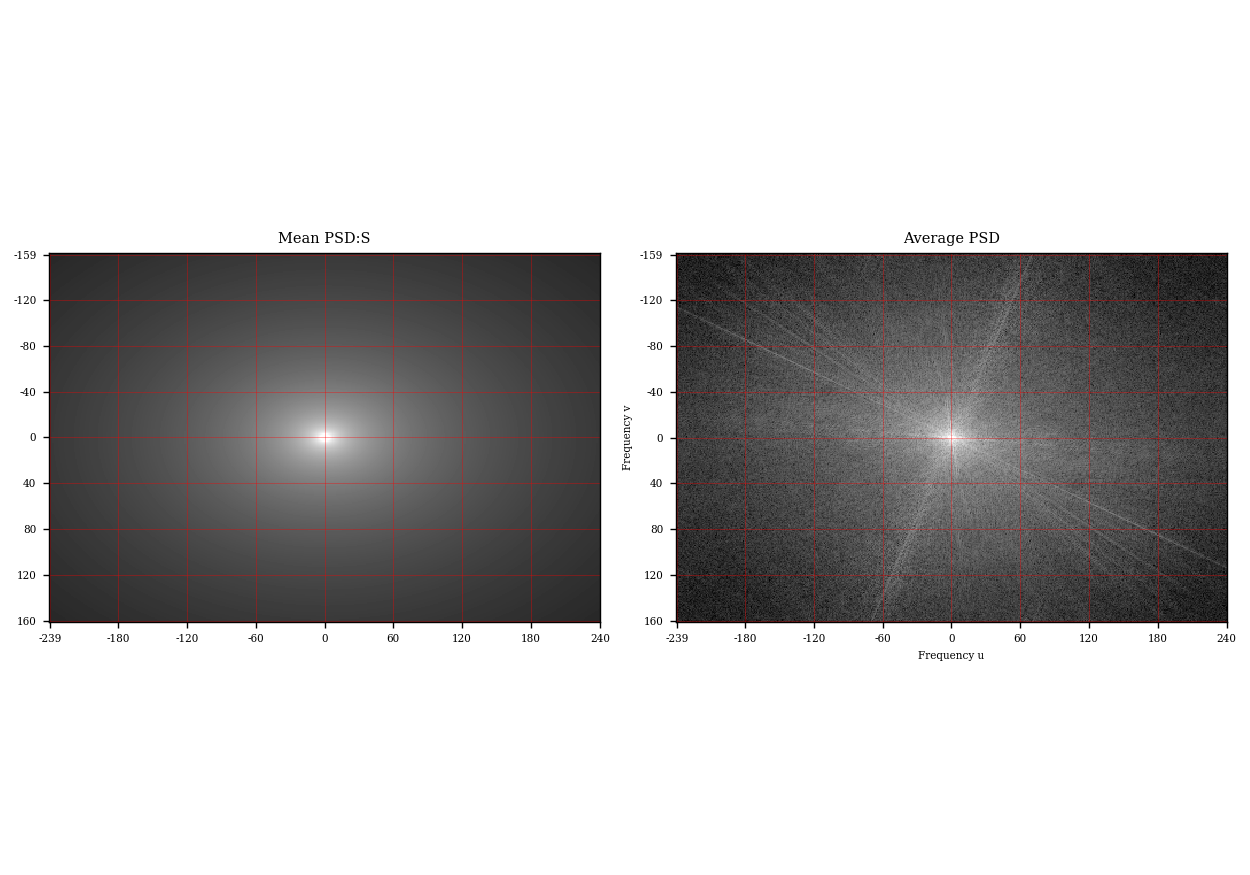

In [509]:


fig, axes = plt.subplots(ncols=2, figsize=(10, 7))

im0.showfft(mpsd, apply_log=True, vmin=-10, vmax=5, ax=axes[0])
axes[0].set_title('Mean PSD:S')

im0.showfft(apsd, apply_log=True, vmin=-10, vmax=5,ax=axes[1])
axes[1].set_title('Average PSD')
plt.xlabel('Frequency u')
plt.ylabel('Frequency v')
fig.show()

<IPython.core.display.Javascript object>


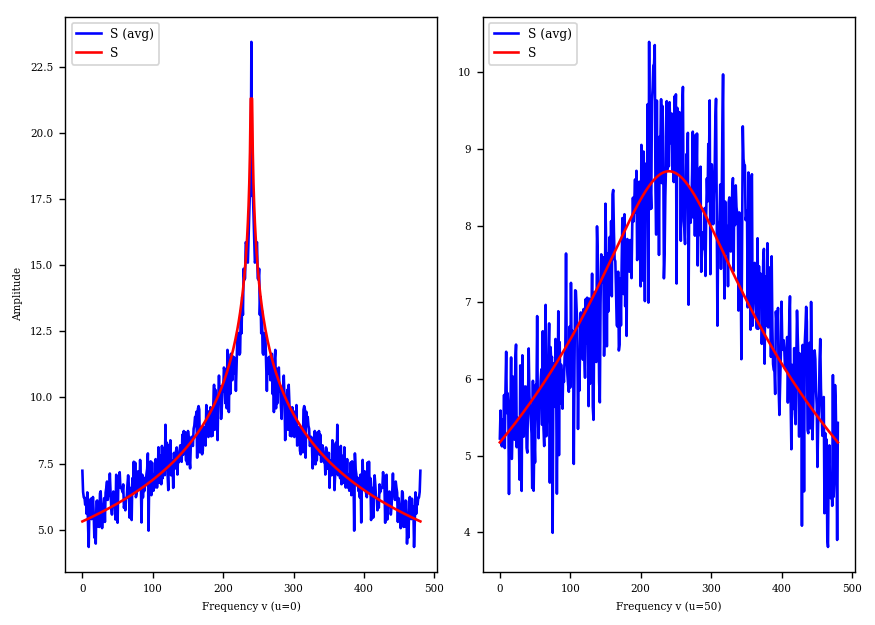

In [569]:
fig,ax =plt.subplots(ncols=2, figsize=(7, 5))


ax[0].plot(range(apsd.shape[1]), np.log(npf.fftshift(apsd[0,:])),'b',label='S (avg)')
ax[0].plot(range(mpsd.shape[1]), np.log(npf.fftshift(mpsd[0,:])),'r', label = 'S')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Frequency v (u=0)')
ax[0].legend(loc='upper left')

ax[1].plot(range(apsd.shape[1]), np.log(npf.fftshift(apsd[50,:])),'b',label='S (avg)')
ax[1].plot(range(mpsd.shape[1]), np.log(npf.fftshift(mpsd[50,:])),'r', label = 'S')
ax[1].set_xlabel('Frequency v (u=50)')
ax[1].legend(loc='upper left')

# 1.2 Wiener Deconvolution
## Question 8

<IPython.core.display.Javascript object>


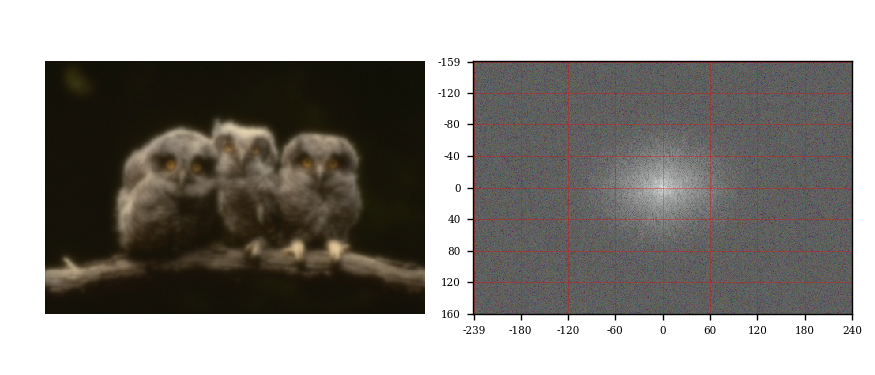

In [373]:
y = plt.imread('assets/owls_blur.png')
def plot_transform(x):
    fig, axes = plt.subplots(ncols=2, figsize=(7,3))
    im0.show(x, ax=axes[0])
    im0.showfft(x, apply_log=True,ax=axes[1], apply_fft=True)
    fig.show()
plot_transform_im(y)

## Question 9

In [481]:
kern = im.kernel('exponential', tau = 2)
n1,n2,_ = y.shape
kern_fft = im.kernel2fft(kern, n1, n2)

## Question 10
The reconstruction is imperfect as there is some loss of information in the forward and backward processes

In [570]:
def deconvolve_naive(y, lbd, return_transfer=False):
    n1,n2, _ = y.shape
    
    hhat =np.conjugate(lbd)/(lbd*lbd)
    

    xdec = im.convolvefft(y,hhat)

    if return_transfer:

        return xdec, hhat
    else:
        return xdec


In [489]:
xdec,h_hat = deconvolve_naive(y,kern_fft,return_transfer=True)
sig = 1/255

<IPython.core.display.Javascript object>


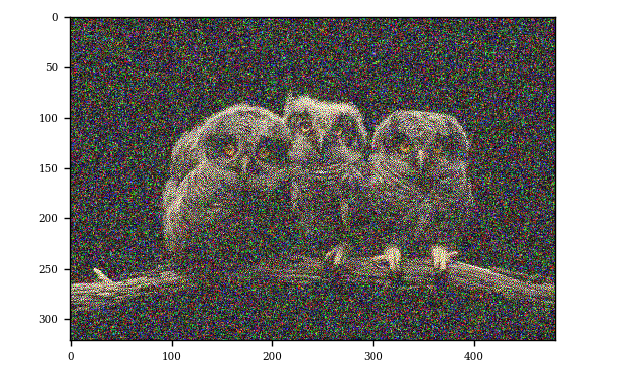

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [469]:
plt.figure()
plt.imshow(xdec)

## Question 11

The exponential one has the best reconstruction, it has the smallest condition number implying the inversion of the matrix poses the least problems numerically.

<IPython.core.display.Javascript object>


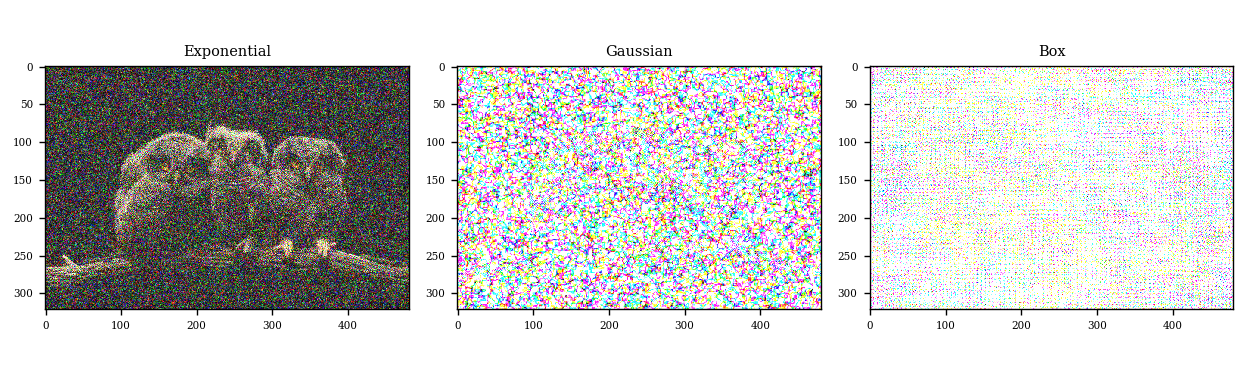

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Exponent Cond  2.6117627230479984e+17
Gauss Cond  3.7536926323621044e+19
Box Cond  7.64926237151842e+19


In [584]:
def naive_dec(name ='exponential'):   
    y = plt.imread('assets/owls_blur.png')
    kern = im.kernel(name, tau = 2)
    n1,n2,_ = y.shape
    kern_fft = im.kernel2fft(kern, n1, n2)
    xdec,h_hat = deconvolve_naive(y,kern_fft,return_transfer=True)
    sig = 1/255
    cond = np.linalg.cond(h_hat)
    
    return xdec,cond
x_exp,cond_exp = (naive_dec('exponential'))
x_gauss,cond_gauss = (naive_dec('gaussian'))
x_box,cond_box =(naive_dec('box'))

fig,ax =plt.subplots(ncols=3, figsize=(10, 3))


ax[0].imshow(x_exp)
ax[0].set_title('Exponential')
ax[1].imshow(x_gauss)
ax[1].set_title('Gaussian')
ax[2].imshow(x_box)
ax[2].set_title('Box')

print('Exponent Cond ', cond_exp)
print('Gauss Cond ', cond_gauss)
print('Box Cond ', cond_box)

## Question 12

As $\sigma$ approaches 0 it becomes similar to the h in the naive approach, as $\sigma$ gets larger the regularization effect is greater and is seldom ill-conditined

## Question 13

In [464]:
def deconvolve_wiener(x, lbd, sig, mpsd, return_transfer=False):
    n1,n2, _ = y.shape
    
    hhat =np.conjugate(lbd)/((lbd*lbd)+(n1*n2*sig**2)/mpsd)
    

    xdec = im.convolvefft(y,hhat)

    if return_transfer:

        return xdec, hhat
    else:
        return xdec

In [590]:
x_dec_weiner,h_hat_w = deconvolve_wiener(y, kern_fft, sig, mpsd, return_transfer=True)

<IPython.core.display.Javascript object>


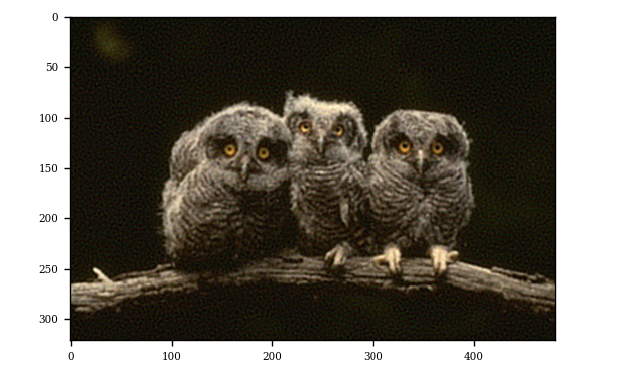

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [591]:
plt.figure()
plt.imshow(x_dec_weiner)

<IPython.core.display.Javascript object>


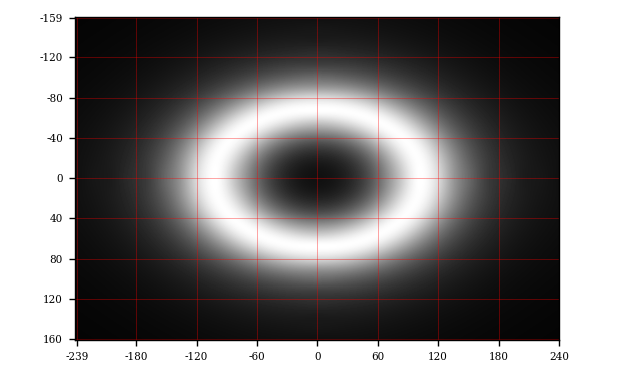

In [495]:
plt.figure()

im0.showfft(h_hat_w)

<IPython.core.display.Javascript object>


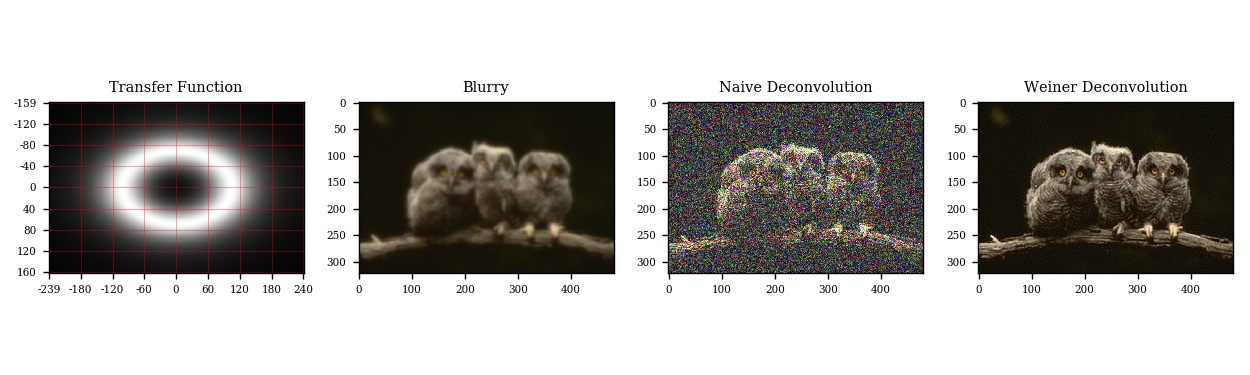

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.3686598466453517e+18


In [592]:
fig,ax =plt.subplots(ncols=4, figsize=(10, 3))


im0.showfft(h_hat_w,ax=ax[0])
ax[0].set_title('Transfer Function')
ax[1].imshow(y)
ax[1].set_title('Blurry')
ax[2].imshow(x_exp)
ax[2].set_title('Naive Deconvolution')
ax[3].imshow(x_dec_weiner)
ax[3].set_title('Weiner Deconvolution')

print(np.linalg.cond(h_hat_w))

## Question 14

Weiner Deconvolution regularises the process by taking into account the power of the signal in the transfer function, the power spectrum ensures the h has a very small condition number

In [596]:
def naive_dec_0(name ='exponential'):   
    y = plt.imread('assets/owls_blur.png')
    kern = im.kernel(name, tau = 2)
    n1,n2,_ = y.shape
    kern_fft = im.kernel2fft(kern, n1, n2)
    sig = 1/255
    x_dec_weiner,h_hat_w = deconvolve_wiener(y, kern_fft, sig, mpsd, return_transfer=True)
    
    cond = np.linalg.cond(h_hat)
    
    return x_dec_weiner

## Question 15
Again, the exponential kernel is best but this time there is a slighter dropoff in the performance

<IPython.core.display.Javascript object>


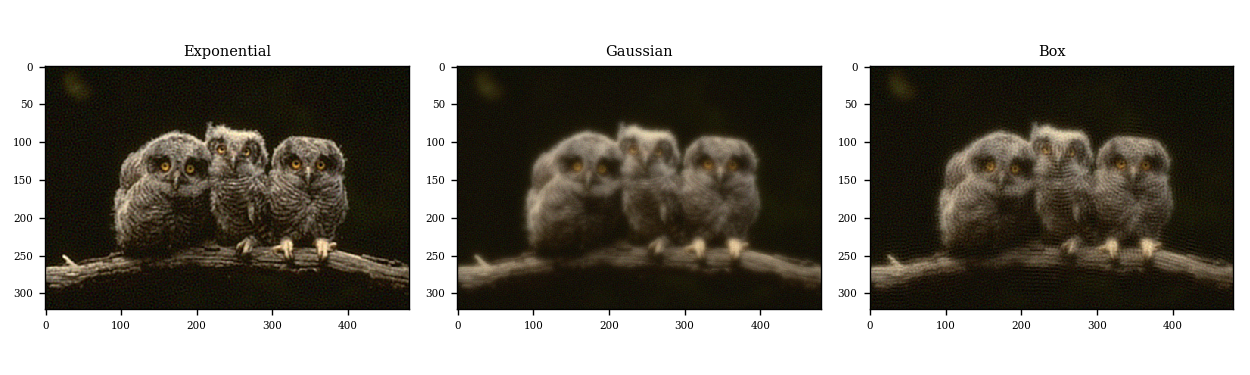

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Box')

In [598]:
x_exp = (naive_dec_0('exponential'))
x_gauss = (naive_dec_0('gaussian'))
x_box =(naive_dec_0('box'))

fig,ax =plt.subplots(ncols=3, figsize=(10, 3))


ax[0].imshow(x_exp)
ax[0].set_title('Exponential')
ax[1].imshow(x_gauss)
ax[1].set_title('Gaussian')
ax[2].imshow(x_box)
ax[2].set_title('Box')